In [ ]:
pip install torch_geometric

In [ ]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


In [ ]:
pip install rdkit

In [38]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import pandas as pd
data_path = '/content/HIV.csv'
data = pd.read_csv(data_path)
data.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [ ]:
data.shape

(41913, 3)

In [ ]:
data['HIV_active'].value_counts()

HIV_active
0    40426
1     1487
Name: count, dtype: int64

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw, rdmolops


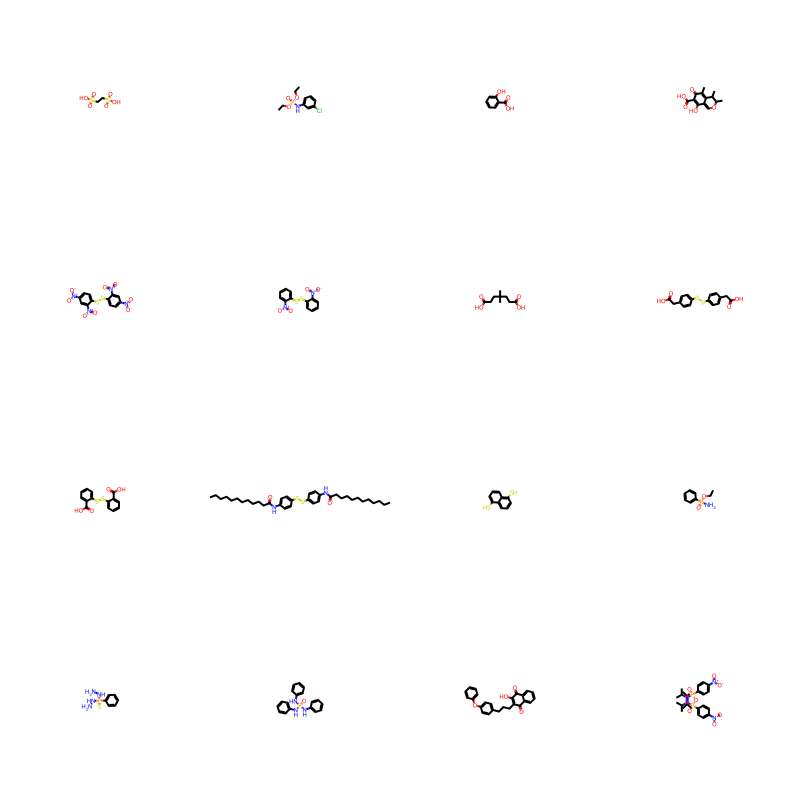

In [ ]:
sample_smiles = data['smiles'][4:20].values
sample_mols = [Chem.MolFromSmiles(smiles) for smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols, molsPerRow=4,subImgSize=(200,200))
grid

In [ ]:
from torch_geometric.data import Dataset, Data
import os
import numpy as np
from tqdm import tqdm
import torch
import deepchem as dc

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
class MoleculeDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data).
        """

        super(MoleculeDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)
        """
        return 'HIV.csv'

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0])

        return [f'data_test_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        #self.data.index = self.data["index"]
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["smiles"])
            f = featurizer._featurize(mol)
            data = f.to_pyg_graph()
            data.y = self._get_labels(row["HIV_active"])
            data.smiles = row["smiles"]
            # # Get node features
            # node_feats = self._get_node_features(mol_obj)
            # # Get edge features
            # edge_feats = self._get_edge_features(mol_obj)
            # # Get adjacency info
            # edge_index = self._get_adjacency_info(mol_obj)
            # # Get labels info
            # label = self._get_labels(mol["HIV_active"])

            # # Create data object
            # data = Data(x=node_feats,
            #             edge_index=edge_index,
            #             edge_attr=edge_feats,
            #             y=label,
            #             smiles=mol["smiles"]
            #             )

            torch.save(data,
                    os.path.join(self.processed_dir,
                                 f'data_test_{index}.pt'))

    def _get_node_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # # Feature 6: Total Num Hs
            # node_feats.append(atom.GetTotalNumHs())
            # # Feature 7: Radical Electrons
            # node_feats.append(atom.GetNumRadicalElectrons())
            # # Feature 8: In Ring
            # node_feats.append(atom.IsInRing())
            # # Feature 9: Chirality
            # node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats.append(edge_feats)

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """

        adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo, (2,-1))
        return torch.tensor(coo, dtype=torch.long)
        # edge_indices = []
        # for bond in mol.GetBonds():
        #     i = bond.GetBeginAtomIdx()
        #     j = bond.GetEndAtomIdx()
        #     edge_indices += [[i, j], [j, i]]

        # edge_indices = torch.tensor(edge_indices)
        # edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        # return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """

        data = torch.load(os.path.join(self.processed_dir,
                                 f'data_test_{idx}.pt'))

        return data

dataset = MoleculeDataset(root="data/")

Processing...
 85%|████████▌ | 35821/41913 [09:13<01:09, 87.27it/s][05:35:00] WARNING: not removing hydrogen atom without neighbors
[05:35:00] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 41913/41913 [10:55<00:00, 63.91it/s]
Done!


In [ ]:
data.shape

(41913, 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install deepchem

In [ ]:
# Check how many additional samples we need
neg_class = data["HIV_active"].value_counts()[0]
pos_class = data["HIV_active"].value_counts()[1]
multiplier = int(neg_class/pos_class) - 1

In [ ]:
# Replicate the dataset for the positive class
#replicated_pos = [data[data["HIV_active"] == 1]]*multiplier
positive_class = data[data["HIV_active"] == 1]
replicated_pos = pd.concat([positive_class] * multiplier, ignore_index=True)

#replicated_pos = pd.DataFrame(replicated_pos)
# Append replicated data
data = pd.concat([data, replicated_pos], ignore_index=True)
print(data.shape)

# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)


(80575, 3)


In [39]:
# Re-assign index (This is our ID later)


# %% Save
data.to_csv("data/raw/HIV_train_oversampled.csv")

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)


In [58]:

class GNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 1024
        n_heads=3
        dropout_rate = 0.3
        top_k_ratio = 0.5


        self.embedding_size = model_params.get('embedding_size', 64)
        self.n_heads = model_params.get('n_heads', 3)
        self.top_k_every_n = model_params.get('top_k_every_n', 1)
        self.top_k_ratio = model_params.get('top_k_ratio', 0.5)
        self.n_layers = model_params["model_layers"]
        dropout_rate = model_params["model_dropout_rate"]
        dense_neurons = model_params["model_dense_neurons"]
        edge_dim = model_params["model_edge_dim"]

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size,
                                    embedding_size,
                                    heads=n_heads,
                                    dropout=dropout_rate,
                                    edge_dim=edge_dim,
                                    beta=True)

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size,
                                                    embedding_size,
                                                    heads=n_heads,
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))


        # Linear layers
        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons/2))
        self.linear3 = Linear(int(dense_neurons/2), 1)

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.transf1(x))
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            x = self.bn_layers[i](x)
            # Always aggregate last layer
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))

        x = sum(global_representation)

        # Output block
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return x
    # def __init__(self, feature_size):
    #     super(GNN, self).__init__()
    #     num_classes = 2
    #     embedding_size = 1024

    #     # GNN Layers

    #     self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
    #     self.head_transform1 = Linear(embedding_size*3, embedding_size)
    #     self.pool1= TopKPooling(embedding_size, ratio=0.8)
    #     self.conv2 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
    #     self.head_transform2 = Linear(embedding_size*3, embedding_size)
    #     self.pool2= TopKPooling(embedding_size, ratio=0.5)
    #     self.conv3 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
    #     self.head_transform3 = Linear(embedding_size*3, embedding_size)
    #     self.pool3= TopKPooling(embedding_size, ratio=0.2)

    #     # Linear layers
    #     self.linear1 = Linear(embedding_size*2, 1024)
    #     self.linear2 = Linear(1024, num_classes)

    # def froward(self, x, edge_attr, edge_index, batch_index):
    #    # first block
    #    x = self.conv1(x, edge_index)
    #    x = self.head_transform1(x)

    #    x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x,
    #                                                            edge_index,
    #                                                            none,
    #                                                            batch_index)

    #    x1 = troch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

    #    # second block
    #    x = self.conv2(x, edge_index)
    #    x = self.head_transform2(x)

    #    x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x,
    #                                                            edge_index,
    #                                                            none,
    #                                                            batch_index)
    #    x2 = troch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

    #    # third block
    #    x = self.conv3(x, edge_index)
    #    x = self.head_transform3(x)

    #    x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x,
    #                                                            edge_index,
    #                                                            none,
    #                                                            batch_index)
    #    x3 = troch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

    #    x = x1 + x2 + x3

    #   # output block
    #    x = self.linear1(x).relu()
    #    x = F.dropout(x, p= 0.5, training= self.training)
    #    x = self.linear2(x)

    #    return x







In [ ]:
import torch
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
from dataset_featurizer import MoleculeDataset
from model import GNN
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Torch version: 2.3.0+cu121
Cuda available: False
Torch geometric version: 2.5.3


In [45]:
# Specify tracking server
mlflow.set_tracking_uri("/content/sample_data")



def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [46]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch.x.float(),
                                batch.edge_attr.float(),
                                batch.edge_index,
                                batch.batch)
        # Calculating the loss and gradients
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss.backward()
        optimizer.step()
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step


In [47]:
def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)
        pred = model(batch.x.float(),
                        batch.edge_attr.float(),
                        batch.edge_index,
                        batch.batch)
        loss = loss_fn(torch.squeeze(pred), batch.y.float())

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(all_preds_raw[0][:10])
    print(all_preds[:10])
    print(all_labels[:10])
    calculate_metrics(all_preds, all_labels, epoch, "test")
    log_conf_matrix(all_preds, all_labels, epoch)
    return running_loss/step


In [48]:
def log_conf_matrix(y_pred, y_true, epoch):
    # Log confusion matrix as image
    cm = confusion_matrix(y_pred, y_true)
    classes = ["0", "1"]
    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
    cfm_plot.figure.savefig(f'data/images/cm_{epoch}.png')
    mlflow.log_artifact(f"data/images/cm_{epoch}.png")


In [49]:

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    mlflow.log_metric(key=f"Precision-{type}", value=float(prec), step=epoch)
    mlflow.log_metric(key=f"Recall-{type}", value=float(rec), step=epoch)
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")

In [ ]:
from mango.tuner import  Tuner
from mango import scheduler
from config import HYPERPARAMETERS, BEST_PARAMETERS, SIGNATURE


In [50]:
def run_one_training(params):
    params = params[0]
    with mlflow.start_run() as run:
        # Log parameters used in this experiment
        for key in params.keys():
            mlflow.log_param(key, params[key])

        # Loading the dataset
        print("Loading dataset...")
        train_dataset = MoleculeDataset(root="data/", filename="HIV_train_oversampled.csv")
        test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)
        params["model_edge_dim"] = train_dataset[0].edge_attr.shape[1]

        # Prepare training
        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=True)

        # Loading the model
        print("Loading model...")
        model_params = {k: v for k, v in params.items() if k.startswith("model_")}
        model = GNN(feature_size=train_dataset[0].x.shape[1], model_params=model_params)
        model = model.to(device)
        print(f"Number of parameters: {count_parameters(model)}")
        mlflow.log_param("num_params", count_parameters(model))

        # < 1 increases precision, > 1 recall
        weight = torch.tensor([params["pos_weight"]], dtype=torch.float32).to(device)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=params["learning_rate"],
                                    momentum=params["sgd_momentum"],
                                    weight_decay=params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])

        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(300):
            if early_stopping_counter <= 10: # = x * 5
                # Training
                model.train()
                loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
                print(f"Epoch {epoch} | Train Loss {loss}")
                mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

                # Testing
                model.eval()
                if epoch % 5 == 0:
                    loss = test(epoch, model, test_loader, loss_fn)
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

                    # Update best loss
                    if float(loss) < best_loss:
                        best_loss = loss
                        # Save the currently best model
                        mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1

                scheduler.step()
            else:
                print("Early stopping due to no improvement.")
                return [best_loss]
    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]

In [51]:
# %% Hyperparameter search
config = dict()
config["optimizer"] = "Bayesian"
config["num_iteration"] = 100


In [52]:
experiment_name = "my_experiment"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/content/sample_data/581978168446707627', creation_time=1720590517845, experiment_id='581978168446707627', last_update_time=1720590517845, lifecycle_stage='active', name='my_experiment', tags={}>

In [60]:
tuner = Tuner(HYPERPARAMETERS,
              objective=run_one_training,
              conf_dict=config)
results = tuner.minimize()

# Print the results
print("Best parameters:", results)

Loading dataset...
Loading model...
Number of parameters: 51207425


100%|██████████| 1310/1310 [1:23:25<00:00,  3.82s/it]


ValueError: Input y_true contains NaN.

In [61]:
print("Number of NaN values in 'HIV_active':", data['HIV_active'].isna().sum())

Number of NaN values in 'HIV_active': 0
